### Datos de los estudiantes:

**Curso**: Ciencia de Datos con Python

**Nombre**: Nery Fuentes  **Carne**: 15004337

**Nombre**: Samuel Ramos  **Carne**: 24000214

**Curso**: Ciencia de Datos con Python


**Sección**: U

### [Video Explicativo](https://youtu.be/0FY1W7n88YY 'Video Explicativo')

# Proyecto AWS
Desarrollar un pipeline de ingeniería de datos utilizando Python, SQL y AWS como herramientas de desarrollo.

## Coneccion a AWS

In [34]:
import boto3
import pandas as pd
import numpy as np
import psycopg2
import configparser
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns

## Autenticacion con AWS

In [4]:
config =configparser.ConfigParser()
config.read(r'./cnf/config.cfg')

['./cnf/config.cfg']

In [5]:
aws_rds_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                             aws_secret_access_key=config.get('IAM','SECRET_ACCESS_KEY') ,
                             region_name='us-east-2')

In [6]:
rds_instances_ids =[]

aws_response = aws_rds_conn.describe_db_instances()

for response in aws_response['DBInstances']:
    rds_instances_ids.append(response['DBInstanceIdentifier'])
    
print("Instancias disponibles: ",rds_instances_ids)

Instancias disponibles:  ['ins-ventas']


### Se crea instancia de base de datos

In [8]:
try:
    response = aws_rds_conn.create_db_instance(
        DBInstanceIdentifier =config.get('TRANSACC','DB_INSTANCE_ID'),
        DBName =config.get('TRANSACC','DB_NAME'),
        DBInstanceClass='db.t3.micro',
        Engine='postgres',
        MasterUsername=config.get('TRANSACC','DB_USER'),
        MasterUserPassword=config.get('TRANSACC','DB_PASSWORD'),
        Port=int(config.get('TRANSACC','DB_PORT')),
        PubliclyAccessible=True,
        VpcSecurityGroupIds=[config.get('VPC','SECURITY_GROUP')],
        AllocatedStorage=15
    )
    print(response)
except aws_rds_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La instancia ya existe ")
except Exception as ex:
    print("error", ex)

error An error occurred (InvalidParameterValue) when calling the CreateDBInstance operation: Invalid security group , groupId= sg-06d08e884a3625166, groupName=.


### Obtenemos el hostname de la instancia

In [41]:
try:
    instance=aws_rds_conn.describe_db_instances(DBInstanceIdentifier=config.get('TRANSACC','DB_INSTANCE_ID') )

    RDS_HOSTNAME = instance.get("DBInstances")[0].get("Endpoint").get("Address")
    print(RDS_HOSTNAME)
except Exception as ex:
    print(ex)

ins-ventas.cz44c6ke2dcw.us-east-2.rds.amazonaws.com


### Conectarse a la BD desde Python

In [39]:
import abcd

abcd.DDL_QUERY

'\nCREATE TABLE IF NOT EXISTS public.usuario\n(\n    idusuario serial,\n    idrol integer,\n    nombre character varying(100) COLLATE pg_catalog."default",\n    tipo_documento character varying(20) COLLATE pg_catalog."default",\n    num_documento character varying(20) COLLATE pg_catalog."default",\n    direccion character varying(70) COLLATE pg_catalog."default",\n    telefono character varying(20) COLLATE pg_catalog."default",\n    email character varying(50) COLLATE pg_catalog."default",\n    clave character varying(1000) COLLATE pg_catalog."default",\n    estado integer,\n    CONSTRAINT usuario_pkey PRIMARY KEY (idusuario)\n);\n\nCREATE TABLE IF NOT EXISTS public.rol\n(\n    idrol  serial,\n    nombre character varying(30) COLLATE pg_catalog."default",\n    descripcion character varying(255) COLLATE pg_catalog."default",\n    estado bit(1),\n    CONSTRAINT rol_pkey PRIMARY KEY (idrol)\n);\n\nCREATE TABLE IF NOT EXISTS public.articulo\n(\n    idarticulo serial,\n    idcategoria integ

### Creacion de estructuras

In [40]:
try:
    db_pg_conn = psycopg2.connect(
        database= config.get('TRANSACC','DB_NAME'),
        user= config.get('TRANSACC','DB_USER'),
        password= config.get('TRANSACC','DB_PASSWORD'),
        host =RDS_HOSTNAME,
        port=config.get('TRANSACC','DB_PORT')
    )

    cursor = db_pg_conn.cursor()
    cursor.execute(abcd.DDL_QUERY)

    db_pg_conn.commit()

    print("base de datos creada")
except Exception as ex:
    print("error!", ex)


base de datos creada


#### INSERTAR DATOS

In [28]:
USER = config.get('TRANSACC', 'DB_USER')
PASSWORD = config.get('TRANSACC', 'DB_PASSWORD')
HOST = RDS_HOSTNAME
PORT =config.get('TRANSACC', 'DB_PORT')
DATABASE =config.get('TRANSACC', 'DB_NAME')

driver = f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"
engine = sqlalchemy.create_engine(driver)

# Función para insertar datos
def insertData2SQL(data_dict, table_name, engine):
    df_data = pd.DataFrame.from_records(data_dict)
    try:
        response = df_data.to_sql(table_name, engine, index=False, if_exists="append")
        print(f"Se han insertado {len(df_data)} nuevos registros en la tabla {table_name}")
    except Exception as ex:
        print(ex)

# Insertar datos en todas las tablas
data_roles = [
    {'nombre': f'Rol {i}', 'descripcion': f'Descripción del rol {i}', 'estado': '1'} for i in range(1, 16)
]
data_usuarios = [
    {'idusuario':f'{i}','idrol': 1, 'nombre': f'Usuario {i}', 'tipo_documento': 'DNI', 'num_documento': f'1234500{i}', 'direccion': f'Calle {i}', 'telefono': f'555-100{i}', 'email': f'user{i}@example.com', 'clave': f'clave{i}', 'estado': 1} for i in range(1, 16)
]

data_articulos = [
    {'idcategoria': i % 4 + 1, 'codigo': f'COD{i:03}', 'nombre': f'Articulo {i}', 'precio_venta': 100 + i, 'stock': 10 + i, 'descripcion': f'Descripción del artículo {i}', 'imagen': f'img{i}.jpg', 'estado': '1'} for i in range(1, 16)
]
data_categorias = [
    {'nombre': f'Categoría {i}', 'descripcion': f'Descripción de la categoría {i}', 'estado': '1'} for i in range(1, 16)
]
data_ventas = [
    {'idventa':f'{i}','idcliente': i, 'idusuario': i, 'tipo_comprobante': 'Factura', 'serie_comprobante': f'F{i:03}', 'num_comprobante': f'N00{i}', 'fecha': '2024-01-01', 'impuesto': 15.00, 'total': 100.00 * i, 'estado': 'Finalizado'} for i in range(1, 16)
]
data_personas = [
    {'tipo_persona': 'Cliente', 'nombre': f'Cliente {i}', 'tipo_documento': 'DNI', 'num_documento': f'1234560{i}', 'direccion': f'Calle {i}', 'telefono': f'555-120{i}', 'email': f'cliente{i}@example.com'} for i in range(1, 16)
]
data_detalle_venta = [
    {'idventa': i, 'idarticulo': i, 'cantidad': i, 'precio': 100 + i * 5, 'descuento': i} for i in range(1, 16)
]
data_ingresos = [
    {'idproveedor': i, 'idusuario': i, 'tipo_comprobante': 'Recibo', 'serie_comprobante': f'R{i:03}', 'num_comprobante': f'N00{i}', 'fecha': '2024-01-02', 'impuesto': 12.00, 'total': 200.00 * i, 'estado': 'Recibido'} for i in range(1, 16)
]
data_detalle_ingreso = [
    {'idingreso': i, 'idarticulo': i, 'cantidad': 10 + i, 'precio': 20.00 * i} for i in range(1, 16)
]

# Ejecución de inserciones
insertData2SQL(data_roles, 'rol', engine)
insertData2SQL(data_usuarios, 'usuario', engine)
insertData2SQL(data_categorias, 'categoria', engine)
insertData2SQL(data_articulos, 'articulo', engine)
insertData2SQL(data_articulos, 'articulo', engine)
insertData2SQL(data_personas, 'persona', engine)
insertData2SQL(data_ventas, 'venta', engine)
insertData2SQL(data_detalle_venta, 'detalle_venta', engine)
insertData2SQL(data_detalle_ingreso, 'detalle_ingreso', engine)


Se han insertado 15 nuevos registros en la tabla detalle_ingreso


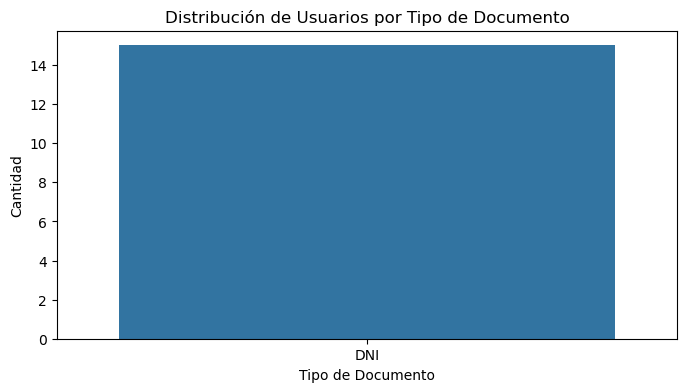

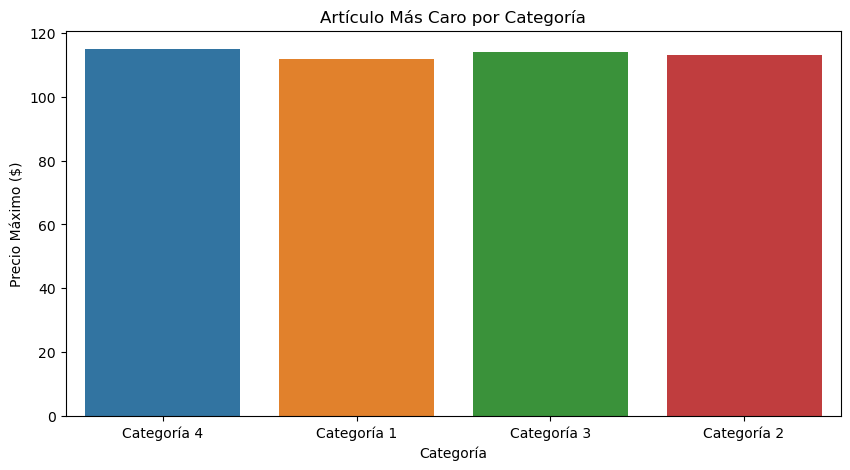

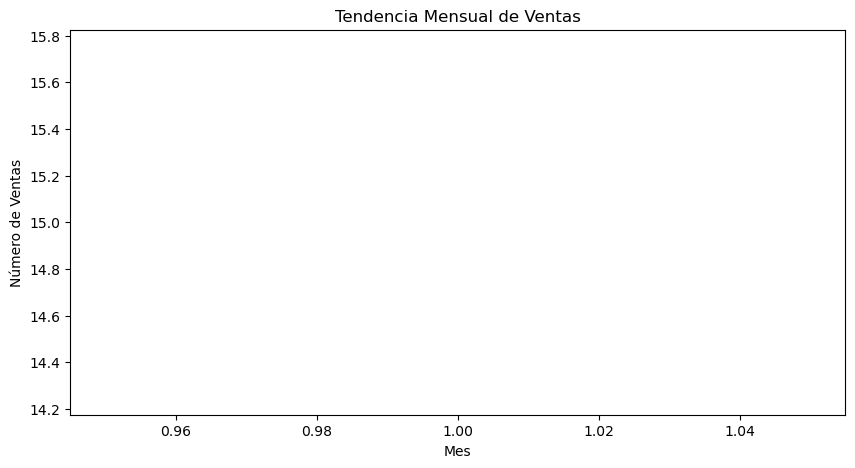

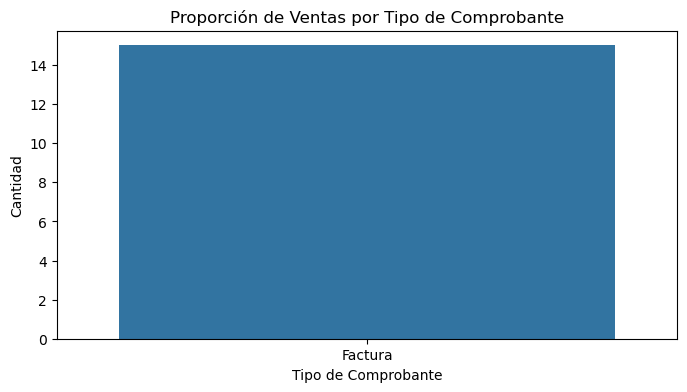

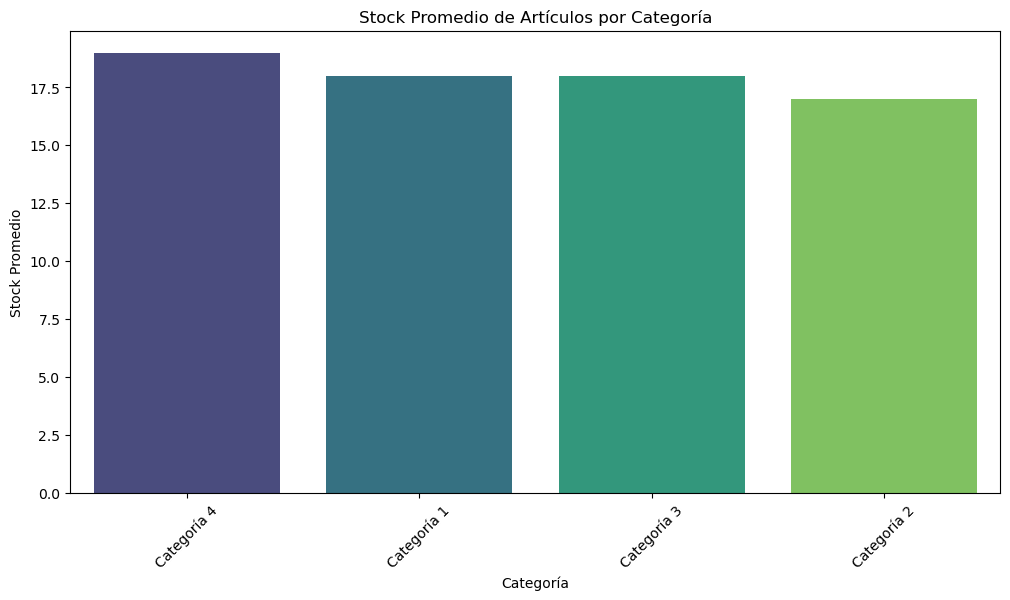

In [35]:
# 1. Distribución de usuarios por tipo de documento
query1 = "SELECT tipo_documento, COUNT(*) as count FROM public.usuario GROUP BY tipo_documento;"
df1 = pd.read_sql_query(query1, engine)
plt.figure(figsize=(8, 4))
sns.barplot(x='tipo_documento', y='count', data=df1)
plt.title('Distribución de Usuarios por Tipo de Documento')
plt.xlabel('Tipo de Documento')
plt.ylabel('Cantidad')
plt.show()

# 2. Artículo más caro por categoría
query2 = """
SELECT c.nombre as categoria, MAX(a.precio_venta) as precio_maximo
FROM public.articulo a
JOIN public.categoria c ON a.idcategoria = c.idcategoria
GROUP BY c.nombre;
"""
df2 = pd.read_sql_query(query2, engine)
plt.figure(figsize=(10, 5))
sns.barplot(x='categoria', y='precio_maximo', data=df2)
plt.title('Artículo Más Caro por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Precio Máximo ($)')
plt.show()

# 3. Tendencia mensual de ventas
query3 = "SELECT EXTRACT(MONTH FROM fecha) as mes, COUNT(*) as num_ventas FROM public.venta GROUP BY mes ORDER BY mes;"
df3 = pd.read_sql_query(query3, engine)
plt.figure(figsize=(10, 5))
sns.lineplot(x='mes', y='num_ventas', data=df3)
plt.title('Tendencia Mensual de Ventas')
plt.xlabel('Mes')
plt.ylabel('Número de Ventas')
plt.show()

# 4. Proporción de ventas por tipo de comprobante
query4 = "SELECT tipo_comprobante, COUNT(*) as count FROM public.venta GROUP BY tipo_comprobante;"
df4 = pd.read_sql_query(query4, engine)
plt.figure(figsize=(8, 4))
sns.barplot(x='tipo_comprobante', y='count', data=df4)
plt.title('Proporción de Ventas por Tipo de Comprobante')
plt.xlabel('Tipo de Comprobante')
plt.ylabel('Cantidad')
plt.show()

# Query para obtener el stock promedio de artículos por categoría
query5 = """
SELECT c.nombre as categoria, AVG(a.stock) as stock_promedio
FROM public.articulo a
JOIN public.categoria c ON a.idcategoria = c.idcategoria
GROUP BY c.nombre
ORDER BY stock_promedio DESC;
"""
df5 = pd.read_sql_query(query5, engine)

# Gráfico para Stock Promedio por Categoría
plt.figure(figsize=(12, 6))
sns.barplot(x='categoria', y='stock_promedio', data=df5, palette='viridis')
plt.title('Stock Promedio de Artículos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Stock Promedio')
plt.xticks(rotation=45)
plt.show()